### This notebook analyses a corpus containing twelve speeches by each of President's Bush and Obama. It begins  with some exploration of word frequencies and a simple model to detect who is speaking, then compares two methods for Topic Detection.

Some initial notation: <br>
D - number of documents in corpus<br>
N - number of words in vocabulary

In [47]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.preprocessing import normalize
from stop_words import stop_words
from IPython.display import Image
from sparklines import sparklines

In [2]:
# get the files into order and make a list to feed to the sklearn Vectorizer
sorted_files = {'Bush': [], 'Obama': []}
dir_path = os.getcwd()
files = os.listdir(os.path.join(dir_path, 'data'))
for file in files:
    for president in sorted_files.keys():
        if president in file:
            sorted_files[president].append(os.path.join(dir_path, 'data', file))
            continue

overall_list = sorted(sorted_files['Bush']) + sorted(sorted_files['Obama'])

In [ ]:
# stop words contains a list of common uninformative words (from NLTK), lets add some more, relevant to this corpus

stop_words += ['president', 'thank', 'america', 'americans', 'american', 'applause', 'laughter', 'laura', 'nation',
               'nations', 'congress', 'country', 'world', 'know', 'people', 'get', 'got', 'going', 'united', 'states',
               'must', 'us', 'would', 'every', 'also', 'one', 'like', 'make', 'met', 'told', 'want', 'believe',
               'government', 'tonight', 'let', 'said', 'year', 'years', 'new', 'last', 'even']

In [3]:
# Now lets initialise an object from sklearn which will convert our corpus into a DxN count matrix
# The token pattern sed will ignore numbers and other non text characters
# We will start just looking at unigrams

vectorizer_params = {'input': 'filename', 'lowercase': True, 'stop_words': stop_words,
                     'token_pattern': r'(?u)\b[a-zA-Z][a-zA-Z]+\b', 'ngram_range': (1,1)}


def fit_vectorizer(vectorizer_params, reduced_vocab=None):
    vectorizer = CountVectorizer(**vectorizer_params)

    # first call the fit method on the entire corpus to set the vocabulary
    vectorizer.fit(overall_list)

    # create a dictionary to return words from indices
    vocabulary = {idx: key for key, idx in vectorizer.vocabulary_.items()}
    print('Corpus vocab length: {}'.format(len(vocabulary)))
    
    if reduced_vocab is not None:
        
        new_vocab = {}
        idx = 0
        for k, v in vectorizer.vocabulary_.items():
            if v in reduced_vocab.tolist():
                new_vocab[k] = idx
                idx += 1
                
        new_params = copy.deepcopy(vectorizer_params)
        new_params['vocabulary'] = new_vocab
        vectorizer = CountVectorizer(**new_params)
        vectorizer.fit(overall_list)
        vocabulary = {idx: key for key, idx in vectorizer.vocabulary_.items()}
        print('Reduced vocab length: {}'.format(len(vocabulary)))
           
    return vectorizer, vocabulary
    

vectorizer, vocabulary = fit_vectorizer(vectorizer_params)

Corpus vocab length: 7561


In [6]:
# Create some statistics we will use for the analysis


def transform_rank(vectorizer, leave_out:int=None, bush_docs = 12):
    
    # can use this later to leave one document out (to test)
    document_list = copy.deepcopy(overall_list)
    if leave_out is not None:
        test_doc = [document_list.pop(leave_out)]
        print(test_doc)
        test_ngram = vectorizer.transform(test_doc)
    else:
        test_ngram = None
        
    # now transform the corpus to DxN count matrices
    overall_ngrams = vectorizer.transform(document_list)
    num_docs, num_words = overall_ngrams.shape

    bush_ngrams = vectorizer.transform(document_list[:bush_docs])
    obama_ngrams = vectorizer.transform(document_list[bush_docs:])

    # create n-gram rankings for words in vocab for each president
    bush_totals = np.array(bush_ngrams.sum(axis=0))
    bush_ranks = np.argsort(bush_totals)[0, :].tolist()
    obama_totals = np.array(obama_ngrams.sum(axis=0))
    obama_ranks = np.argsort(obama_totals)[0, :].tolist()

    # index the ranks to words to avoid repeating searches
    print('indexing...')
    bush_ranks_indices = {w: bush_ranks.index(w) for w in range(num_words)}
    obama_ranks_indices = {w: obama_ranks.index(w) for w in range(num_words)}
    print('indexing complete')
    
    return overall_ngrams, bush_totals, obama_totals, bush_ranks, obama_ranks, bush_ranks_indices, \
           obama_ranks_indices, test_ngram


overall_ngrams, bush_totals, obama_totals, bush_ranks, obama_ranks, bush_ranks_indices, obama_ranks_indices \
, test_ngram = transform_rank(vectorizer)

indexing...
indexing complete


## Exploration

*First, we can do some very basic analysis with these unigram counts*

In [7]:
# lets have a look at the top ten most frequent words used by each speaker


def top_words():
    bush_top_words = {vocabulary[idx]: bush_totals[0, idx] for idx in bush_ranks[-10:]}
    obama_top_words = {vocabulary[idx]: obama_totals[0, idx] for idx in obama_ranks[-10:]}

    print('Bush top words: {}'.format(bush_top_words))
    print('Obama top words: {}'.format(obama_top_words))
    
    return bush_top_words, obama_top_words


bush_top_words, obama_top_words = top_words()

Bush top words: {'terrorists': 83, 'work': 84, 'time': 87, 'good': 89, 'great': 95, 'health': 104, 'help': 119, 'security': 122, 'iraq': 125, 'freedom': 151}
Obama top words: {'take': 82, 'job': 82, 'energy': 87, 'economy': 92, 'help': 104, 'right': 111, 'need': 123, 'time': 153, 'jobs': 163, 'work': 174}


*Unsurprisingly, Bush talks a lot about terrorists, Iraq, freedom & security; he also likes to say good & great.*

*Obama seems more focussed on jobs, energy and the economy as well and likes to say need & right.*

*It would be interesting to plot how consistently the top words rank across documents.*

In [8]:
bush_comp = []
obama_comp = []

num_docs, num_words = overall_ngrams.shape

for document_num in tqdm.tnrange(num_docs):
    document_ranks = np.argsort(np.array(overall_ngrams[document_num, :].sum(axis=0)))[0, :].tolist()

    # index the ranks to words to avoid repeating searches
    document_ranks_indices = {w: document_ranks.index(w) for w in range(num_words)}

    true_class = document_num < 12
    if true_class == 1:
        bush_comp.append([len(vocabulary) - document_ranks_indices[r] for r in bush_ranks[-10:]])
    else:
        obama_comp.append([len(vocabulary) - document_ranks_indices[r] for r in obama_ranks[-10:]])

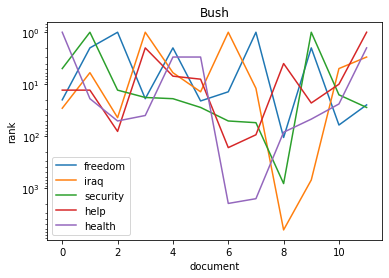

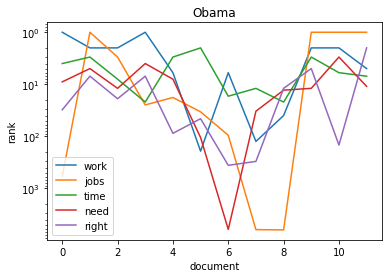

In [9]:
def plot_ranks(num_words, bush_comp, obama_comp):
    plt.figure(1)
    plt.xlabel('document')
    plt.ylabel('rank')
    plt.yscale('log')
    plt.title('Bush')
    bush_comp = np.array(bush_comp)
    for word in range(num_words):
        plt.plot(range(bush_comp.shape[0]), bush_comp[:, -(word+1)], label=list(bush_top_words.keys())[-(word+1)])

    plt.legend(loc=3)
    plt.gca().invert_yaxis()
    plt.show()

    plt.figure(2)
    plt.xlabel('document')
    plt.ylabel('rank')
    plt.yscale('log')
    plt.title('Obama')
    obama_comp = np.array(obama_comp)
    for word in range(num_words):
        plt.plot(range(obama_comp.shape[0]), obama_comp[:, -(word+1)], label=list(obama_top_words.keys())[-(word+1)])

    plt.legend(loc=3)
    plt.gca().invert_yaxis()
    plt.show()
    

num_words = 5
plot_ranks(num_words, bush_comp, obama_comp) 

# Note: we've got a log scale

*Obama is quite consistent in his use of the word 'time', whereas Bush is most consistent with 'Freedom'*

*Perhaps we can predict who is speaking just from this.*

*We'll try, using the 'Out of place' distance measure, which is the average difference in word rank between a document and a reference point (say, the average for Bush or Obama across all speeches, excluding the one being classified).*

*This will require searching through a long list of words many times, we can speed it up by indexing the lists into a dictionaries (already done above), but perhaps we can better narrow down the list first.*

*tf-idf is a common way to discover important words in documents, the term frequency in a document is multiplied by the inverse document frequency (how often the word appears in documents in the corpus). We can then sum these word importances across all documents and pick the ones that score highest overall.*

*We can use the sklearn transformer object to do this.*

In [10]:
transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)


def reduce_vocab(overall_ngrams, num_words):
    overall_tfidf = transformer.fit_transform(overall_ngrams)
    totals = np.array(overall_tfidf.sum(axis=0))

    # selecting the indices of the thousand most important ngrams
    reduced_vocab = np.argsort(totals)[0, -num_words:]
    vectorizer, vocabulary = fit_vectorizer(vectorizer_params, reduced_vocab)
    
    return vectorizer, vocabulary


overall_ngrams = vectorizer.transform(overall_list)
vectorizer, vocabulary = reduce_vocab(overall_ngrams, 1000)

Corpus vocab length: 7561
Reduced vocab length: 1000


The particular variant of tf-idf used here is: 
$$ (log(f_{t,d}) + 1).(log(\frac{1+D}{1+n_{t}}) + 1) $$
Where: <br>
$f_{t,d}$ is the count of the word in the document, here taking the log since the difference between very large numbers should intuitively have less impact than the same difference between small numbers.<br>
$D$ is the number of documents in the corpus<br>
$n_{t}$ is the count of the documents which contain the word

The ones are added throughout to smooth the function i.e avoid division and multiplication by zero.

The following function will loop through each speech, constructing the statistics from all the remaining speeches (i.e. Leave-One-Out cross validation) then attempting to classify the held out speech using the out-of-place distance.

In [11]:
def analyse_ngrams(vectorizer, num_docs):
    scores = []
    
    print('comparing document ranks')
    for document_num in tqdm.tnrange(num_docs):
        bush_docs = 12 - (document_num < 12)
        print('testing document {}'.format(document_num))
        overall_ngrams, bush_totals, obama_totals, bush_ranks, obama_ranks, bush_ranks_indices, obama_ranks_indices \
        , test_ngram = transform_rank(vectorizer, document_num, bush_docs)
        
        num_docs, num_words = overall_ngrams.shape
        document_ranks = np.argsort(np.array(test_ngram.sum(axis=0)))[0, :].tolist()

        # index the ranks to words to avoid repeating searches
        document_ranks_indices = {w: document_ranks.index(w) for w in range(num_words)}

        mean_diff_bush = np.mean(np.abs(np.array([document_ranks_indices[w]
                                                  - bush_ranks_indices[w] for w in range(num_words)])))
        mean_diff_obama = np.mean(np.abs(np.array([document_ranks_indices[w]
                                                   - obama_ranks_indices[w] for w in range(num_words)])))

        true_class = document_num < 12
        predicted_class = mean_diff_bush < mean_diff_obama
        score = true_class == predicted_class
        scores.append(score)
    
    return scores
            
scores = analyse_ngrams(vectorizer, num_docs)
print('Scores: {}'.format(scores))
print('Accuracy {}'.format(np.mean(np.array(scores))))

comparing document ranks


testing document 0
['/Users/graeme/presidents/data/Bush_1.txt']
indexing...
indexing complete
testing document 1
['/Users/graeme/presidents/data/Bush_10.txt']
indexing...
indexing complete
testing document 2
['/Users/graeme/presidents/data/Bush_11.txt']
indexing...
indexing complete
testing document 3
['/Users/graeme/presidents/data/Bush_12.txt']
indexing...
indexing complete
testing document 4
['/Users/graeme/presidents/data/Bush_2.txt']
indexing...
indexing complete
testing document 5
['/Users/graeme/presidents/data/Bush_3.txt']
indexing...
indexing complete
testing document 6
['/Users/graeme/presidents/data/Bush_4.txt']
indexing...
indexing complete
testing document 7
['/Users/graeme/presidents/data/Bush_5.txt']
indexing...
indexing complete
testing document 8
['/Users/graeme/presidents/data/Bush_6.txt']
indexing...
indexing complete
testing document 9
['/Users/graeme/presidents/data/Bush_7.txt']
indexing...
indexing complete
testing document 10
['/Users/graeme/presidents/data/Bush_

*So we can get 92% accuracy classifying a speech to each president, just using word ranks*

*The failures come in speeches where Bush discusses African development and Obama discusses security issues. Perhaps we could make some improvement by using bigrams or by constructing a transition probability matrix and using a Markov chain to model the probability of observations.*

*It's probably more interesting to try a harder task though, so I'll move on to unsupervised topic modelling.*

## Topic Modelling

Lets try to do some topic modelling. I'd like to compare two popular methods, Non-Negative Matrix Factorisation (NMF) and Latent Dirichlet Allocation (LDA).

### NMF Background
NMF is a fairly simple concept. The DxN matrix of word counts is factorised into a DxK matrix of document topic weights and a KxN matrix of topic word weights, i.e. we are finding a latent dimension of length K which represents underying topics. 

$$ X_{dn} = U_{dk}V_{kn}$$

The elements of U and V are restricted to be non-negative and, as such, each document is an additive mixture of underlying topics. This is similar to Principal Components Analysis (PCA), however has the advantage that the components are not restricted to be orthogonal as well as to be non-negative (which fits the underlying problem better).

U and V can be found using various efficient numerical optimisation techniques, minimising either $||X-UV||$ (the Euclidean distance) or $D(X||UV)$. Where for the latter, in the case that the elements of X and UV sum to one (i.e. form probability distributions), $D$ is the Kullback–Leibler Divergence, or relative entropy. Either objective can be implemented with provably monotonic convergence (Lee & Seung, 'Algorithms for Non-negative Matrix Factorization' NIPS 2000), though not necessarily to a global minimum since the loss is non-convex.

The sklearn package provides some choices for weight initialisation which affect the solution (since many solutions are likely possible). I've chosen Nonnegative Double Singular Value Decomposition with zeros filled with the average, which should discourage sparsity and speed up learning. 

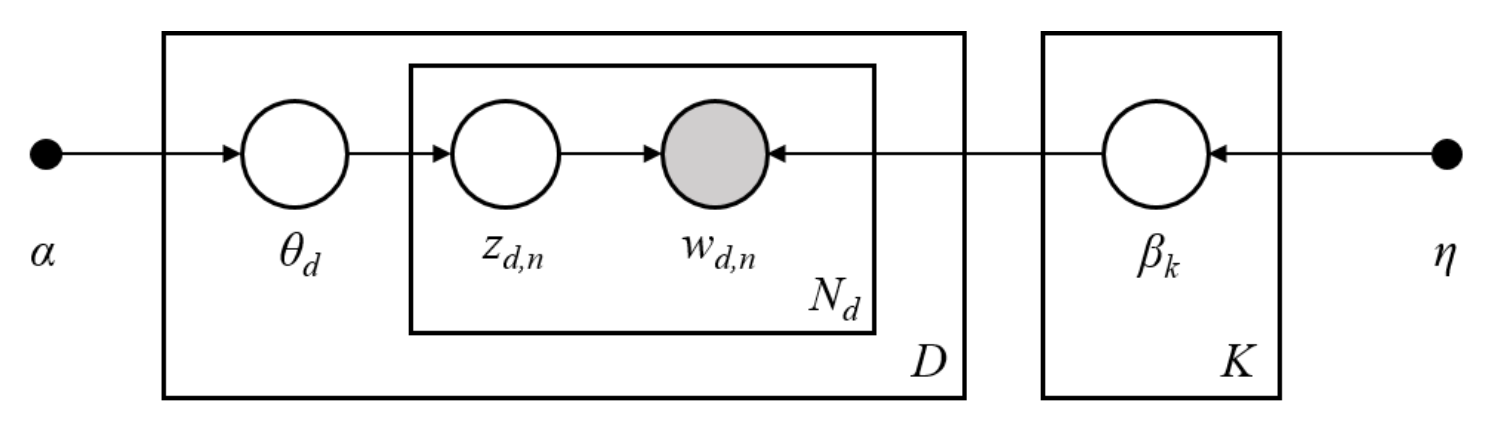

In [46]:
# LDA graphical model from https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation]
Image('LDA.png')

## LDA Background
Latent Dirichlet Allocation is a generative model and can be thought of as a special case of the NMF factorisation, where the probability of word n being found in document d is given by:
$$P(w_{dn}) = \sum_{k}\theta_{dk}\beta_{kn}$$

In its expanded form (see graphical model above), each word $w_{d,n}$ is drawn from a Multinomial distribution parametrised by one of the rows of $\beta$ (i.e. the distribution of words over a topic). Since the Dirichlet distribution is the conjugate prior of the Multinomial, that is chosen to generate $\beta_{k}$, which itself is parameterised by $\eta_{w}$. 

Likewise the choice of topic ($z_{d,n}$) is drawn from a Multinomial distribution, parametrised by the Dirichlet distributed $\theta_{d}$ (one of the columns of $\theta$ above), which itself is parameterised by $\alpha_{k}$.

It is possible to get an intuitive idea for the parameters $\alpha_{k}$ and $\eta_{w}$ by reparameterising the joint distribution in terms of the document and topic word counts $A_{d,k}$ and $B_{k,w}$.
$$p(w,z,\theta,\beta|\alpha,\eta) = \left(\prod_{d} \frac{1}{\rm B(\vec{\alpha})} \prod_{k} \theta_{d,k}^{\alpha + A_{d,k}-1}\right)\left(\prod_{k} \frac{1}{\rm B(\vec{\eta})} \prod_{w} \beta_{k,w}^{\eta + B_{k,w}-1}\right)$$

Where $\rm B(...)$ is the multivariate Beta function and we assume the elements of $\vec{\alpha}$ and $\vec{\eta}$ are a single constant. So increasing $\alpha$ is equivelent to adding to the count of a topic across all documents and increasing $\eta$ is equivelent to adding to the count of a word across all topics.

Whilst it is intractable to infer the posterior distribution exactly, we can use a variational approximation to reparametarise and optimise towards a lower bound (see Blei, Ng & Jordan, 'Latent Dirichlet Allocation', JMLR 2003). Some other methods have since been proposed, but I've used this one below. 

In [15]:
# Both of these methods are quite fast so we can reset the vectorizer to include the full vocabulary

vectorizer, vocabulary = fit_vectorizer(vectorizer_params)
overall_ngrams = vectorizer.transform(overall_list)

Corpus vocab length: 7561


In [38]:
# NNMF 
nnmf_model = NMF(n_components=8, init='nndsvda', solver='mu', beta_loss='kullback-leibler',
                 tol=0.0001, max_iter=200, random_state=0, verbose=True)
doc_topic_matrix = nnmf_model.fit_transform(overall_ngrams)
topic_word_matrix = nnmf_model.components_

Epoch 10 reached after 0.083 seconds, error: 239.988014
Epoch 20 reached after 0.148 seconds, error: 232.853129
Epoch 30 reached after 0.208 seconds, error: 230.778621
Epoch 40 reached after 0.268 seconds, error: 230.163432
Epoch 50 reached after 0.331 seconds, error: 229.875758
Epoch 60 reached after 0.391 seconds, error: 229.718804
Epoch 70 reached after 0.452 seconds, error: 229.711393


In [56]:
# Lets look at the highest weighted words for each topic

print('Top 10 words per topic:')
for topic in range(topic_word_matrix.shape[0]):
    print(topic)
    ngram_ranks = np.argsort(topic_word_matrix[topic, :])
    print([vocabulary[d] for d in ngram_ranks[-10:]])
#     print([vocabulary[d] + str(lda.components_[topic, d])for d in ngram_ranks[-10:]])  # Debugging

Top 10 words per topic:
0
['economy', 'businesses', 'tax', 'energy', 'right', 'need', 'time', 'help', 'work', 'jobs']
1
['health', 'children', 'good', 'economy', 'terror', 'help', 'terrorists', 'iraq', 'freedom', 'security']
2
['iraq', 'security', 'plan', 'help', 'freedom', 'great', 'care', 'time', 'four', 'health']
3
['clear', 'political', 'strategy', 'forces', 'military', 'qaeda', 'troops', 'iraqi', 'war', 'iraq']
4
['help', 'way', 'work', 'malaria', 'school', 'great', 'corruption', 'many', 'kenya', 'africa']
5
['war', 'could', 'security', 'nuclear', 'saddam', 'hussein', 'many', 'enough', 'threat', 'weapons']
6
['small', 'economy', 'europe', 'families', 'businesses', 'right', 'time', 'jobs', 'work', 'freedom']
7
['together', 'economy', 'keep', 'better', 'promise', 'care', 'need', 'change', 'time', 'work']


*There is some overlap between the topics, which may be due to each president's different choice of words for the same topic. Broadly we see topics focussing on either the economy, the war on terror or African development.* 

In [50]:
# Now normalising the topic weights for each document to get a percentage weight for each topic per document, 
# visualised with sparklines

doc_topic_norm_weights = normalize(doc_topic_matrix, axis=1, norm='l1')
print('NMF Topic scores per document:')
for doc in range(doc_topic_norm_weights.shape[0]):
    print(overall_list[doc])
    for line in sparklines(doc_topic_norm_weights[doc, :]):
        print(line)
    print(doc_topic_norm_weights[doc, :])


NMF Topic scores per document:
/Users/graeme/presidents/data/Bush_1.txt
▁▁█▁▁▁▁▁
[1.36215682e-14 2.38031479e-17 1.00000000e+00 1.08522823e-17
 8.93154937e-22 2.98207827e-20 2.71864302e-18 1.20345202e-15]
/Users/graeme/presidents/data/Bush_10.txt
▁█▁▁▁▁▁▁
[1.02470507e-04 9.99523940e-01 3.71468684e-04 1.48495853e-09
 2.75882066e-13 6.33174539e-09 1.42620270e-06 6.86404641e-07]
/Users/graeme/presidents/data/Bush_11.txt
▁█▁▁▁▁▁▁
[7.19029925e-06 9.99977190e-01 3.69019226e-08 5.36994215e-10
 6.51884767e-09 1.73680732e-10 1.52101943e-05 3.65301134e-07]
/Users/graeme/presidents/data/Bush_12.txt
▁█▁▁▁▁▁▁
[1.52735982e-04 9.99847164e-01 1.77905033e-09 4.64375212e-08
 1.84846237e-11 7.97321802e-12 1.14200079e-09 5.05913965e-08]
/Users/graeme/presidents/data/Bush_2.txt
▁▁█▁▁▁▁▁
[3.83331682e-09 5.44269622e-08 9.99999942e-01 1.17954520e-14
 5.08116945e-17 4.36059187e-14 2.80585991e-12 4.83792912e-11]
/Users/graeme/presidents/data/Bush_3.txt
▁▁█▁▁▁▁▁
[2.28853128e-13 2.48501480e-17 1.00000000e+00 1.269

It's noticable that most documents have a very dominant weighting to just one or two topics. This holds even when reducing the number of topics to force them to be more general.

The LDA model gives us more control, through the parameter settings. Below I've set $\alpha$ (which sklearn refer to as the doc_topic_prior) to 10 since a quick glance through some of the speeches reveals they do jump around through topics quite often. I've set $\eta$ (or the topic_word_prior) to a low 0.001 to encourage the model to learn more distinct topics.

The model output is evaluated every 5 iterations by calculating Perplexity, which is a measure of how well a model predicts a sample, given by $2^{H}$ where $H$ is the entropy (i.e. lower is better). Training is stopped when this improves by less than 0.1.

In [42]:
# LDA
lda = LatentDirichletAllocation(n_components=8, random_state=0, verbose=1, topic_word_prior=0.001,
                                doc_topic_prior=10, max_iter=1000, learning_method='batch', evaluate_every=5)
lda.fit(overall_ngrams)

iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000, perplexity: 10825.0525
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000, perplexity: 9055.3593
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000, perplexity: 8556.1187
iteration: 16 of max_iter: 1000
iteration: 17 of max_iter: 1000
iteration: 18 of max_iter: 1000
iteration: 19 of max_iter: 1000
iteration: 20 of max_iter: 1000, perplexity: 8283.8820
iteration: 21 of max_iter: 1000
iteration: 22 of max_iter: 1000
iteration: 23 of max_iter: 1000
iteration: 24 of max_iter: 1000
iteration: 25 of max_iter: 1000, perplexity: 8114.2443
iteration: 26 of max_iter: 1000
iteration: 27 of max_iter: 1000
iteration: 28 of max_iter: 10

iteration: 228 of max_iter: 1000
iteration: 229 of max_iter: 1000
iteration: 230 of max_iter: 1000, perplexity: 7433.7072
iteration: 231 of max_iter: 1000
iteration: 232 of max_iter: 1000
iteration: 233 of max_iter: 1000
iteration: 234 of max_iter: 1000
iteration: 235 of max_iter: 1000, perplexity: 7433.6962


LatentDirichletAllocation(batch_size=128, doc_topic_prior=10, evaluate_every=5,
                          learning_decay=0.7, learning_method='batch',
                          learning_offset=10.0, max_doc_update_iter=100,
                          max_iter=1000, mean_change_tol=0.001, n_components=8,
                          n_jobs=None, perp_tol=0.1, random_state=0,
                          topic_word_prior=0.001, total_samples=1000000.0,
                          verbose=1)

In [55]:
# Again, looking at the top words per topic

print('Top 10 words per topic:')
for topic in range(lda.components_.shape[0]):
    print(topic)
    ngram_ranks = np.argsort(np.array(lda.components_[topic, :]))
    print([vocabulary[d] for d in ngram_ranks[-10:]])
#     print([vocabulary[d] + str(lda.components_[topic, d])for d in ngram_ranks[-10:]])  # Debugging


Top 10 words per topic:
0
['help', 'families', 'future', 'take', 'energy', 'right', 'economy', 'need', 'jobs', 'work']
1
['democracy', 'help', 'women', 'men', 'children', 'free', 'great', 'good', 'freedom', 'security']
2
['mass', 'cause', 'saddam', 'regime', 'citizens', 'terrorists', 'terrorist', 'terror', 'war', 'weapons']
3
['senator', 'small', 'vote', 'social', 'change', 'plan', 'clear', 'sure', 'iraq', 'four']
4
['back', 'stand', 'go', 'never', 'schools', 'see', 'today', 'health', 'time', 'care']
5
['east', 'al', 'war', 'qaida', 'peace', 'trust', 'troops', 'forces', 'iraqi', 'iraq']
6
['helping', 'meeting', 'hiv', 'aids', 'visit', 'malaria', 'threat', 'weapons', 'program', 'africa']
7
['high', 'home', 'hard', 'working', 'next', 'education', 'change', 'businesses', 'tax', 'job']


*The topics here do seem to be a little more specific, with themes on education emerging as well as more nuanced versions of the military themes.*

In [54]:
# And again the distribution of topics over documents, visualised with sparklines

doc_scores = lda.transform(overall_ngrams)
print('Topic scores per document:')
for doc in range(doc_scores.shape[0]):
    print(overall_list[doc])
    for line in sparklines(doc_scores[doc, :]):
        print(line)
    print(doc_scores[doc, :])

Topic scores per document:
/Users/graeme/presidents/data/Bush_1.txt
▁▁▁█▂▁▁▁
[0.04747496 0.05264536 0.0159585  0.69529543 0.08688326 0.02866021
 0.01405515 0.05902713]
/Users/graeme/presidents/data/Bush_10.txt
▁▂▃▂▁▅▁█
[0.03994799 0.08489507 0.12573101 0.09192809 0.0250947  0.23810897
 0.01382904 0.38046513]
/Users/graeme/presidents/data/Bush_11.txt
▁▂▃▂▁▆▁█
[0.04944795 0.05927912 0.11461616 0.05051991 0.0229935  0.2741645
 0.02234019 0.40663867]
/Users/graeme/presidents/data/Bush_12.txt
▁▁▁▁▁█▁▂
[0.04180418 0.05650407 0.03651846 0.03700005 0.02792591 0.67362049
 0.01323087 0.11339597]
/Users/graeme/presidents/data/Bush_2.txt
▂▂▂█▂▂▁▇
[0.05527602 0.05943305 0.08418435 0.34508784 0.05438732 0.07273624
 0.01539402 0.31350116]
/Users/graeme/presidents/data/Bush_3.txt
▁▁▁█▂▁▁▁
[0.04672438 0.06163406 0.01232544 0.7694272  0.06916431 0.01402904
 0.01146019 0.01523538]
/Users/graeme/presidents/data/Bush_4.txt
▁▂█▁▁▃▁▁
[0.03019614 0.066566   0.60479767 0.04712382 0.02789977 0.17927467
 0.02548

*Here we do see more mixing of topics in speeches, with the minor components generally many orders of magnitude bigger than with the NMF model. So it looks like the choice of priors has had the desired effect.*

*The issue with both these models is that they require a lot of tweaking of parameters and subjective evaluation of results. We could however, do some hyper-parameter search, validating with perplexity on a held out set of documents to go about this in a more robust fashion, but that would be a fairly lenghty process so I'll leave that for further work.*

## Discussion

Given the clear differences in style, values and topical subject matter, it is perhaps not surprising that it is quite easy to detect which of the two politicians is speaking from a simple word frequency model. Further improvement from the 92% accuracy is likely possible by engaging more complex sequential methods. 

The BERT model developed at google, for example, utilises several ideas which have proved powerful in recent years, such as RNNs, Attention and relational inductive biases (combined in the Transformer architecture) as well as deep bidirectional context. The base model can be fine tuned to give best in class performance on a variety of natural language processing tasks.

This could be an interesting avenue for topic detection as well, with the opportunity to utilise both the attention layers and the word embeddings. 

As far as improving the models used above goes, there are some alternative algorithms which could give better results, including online learning for LDA. A Heirarchical Dirichlet Process model could learn the number of topics automatically (within a given range). It's also possible to incorporate Bayesian estimates of $\alpha$, to optimise the parameter at each iteration.

For NMF, different initialisation strategies, solvers, stopping conditions and losses could be tried. 